In [2]:
import pathlib
import sys

path = pathlib.Path().resolve().parent
sys.path.insert(0, str(path))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import linregress ,kstest, norm
import statsmodels.api as sm

from src.mixture_fit import error_estimate
from src.data_loading import load_data

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

%matplotlib widget

Preprocessing of 1000 experiments data

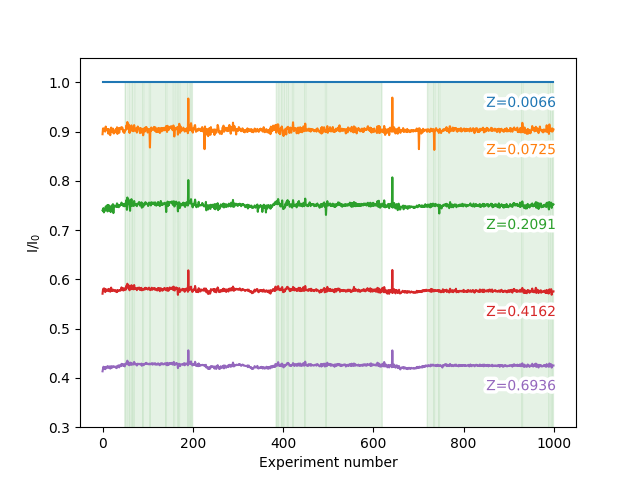

(631, 5)


In [25]:
x, y = np.loadtxt(path.joinpath('data', '1000experiments.txt'), skiprows=1, usecols=[1, 2]).T

x = x.reshape(-1, 5)
y = y.reshape(-1, 5)

y = y / y.max(1).reshape(-1, 1)
x = x / 1e6

prev_sum = 0
mask = np.ones(len(y), dtype=bool)

mask[:50] = False
mask[200:385] = False
mask[620:720] = False

base_mask = mask.copy()
for i in range(1, 5):
    prev_sum = 0
    while prev_sum != mask.sum():
        prev_sum = mask.sum()
        mean, sigma = y[mask].T[i].mean(), y[mask].T[i].std()
        mask = base_mask * (y.T[i] > (mean - 3*sigma)) * (y.T[i] < (mean + 3*sigma))
    base_mask = mask.copy()

x = x[mask]
y_print = y.copy()
y = y[mask]

plt.close()

x_values = np.where(mask)[0]
for i in range(5):
    sl, inter ,_ ,_ ,_  = linregress(x_values, y.T[i])
    p = plt.plot(y_print.T[i])
    plt.annotate(f'Z={x[0, i]:.4f}', [850, y_print.T[i][-1]-0.05], color=p[0].get_color(), path_effects=[pe.withStroke(linewidth=5, foreground="white")])
plt.fill_between(np.arange(0, len(y_print)), 0, y.max()*mask, color='green', alpha=0.1)

idx = 4
plt.ylabel(r'$ \rm I / I_0$')
plt.xlabel('Experiment number')
plt.ylim(bottom=0.3)
plt.show()

print(y.shape)

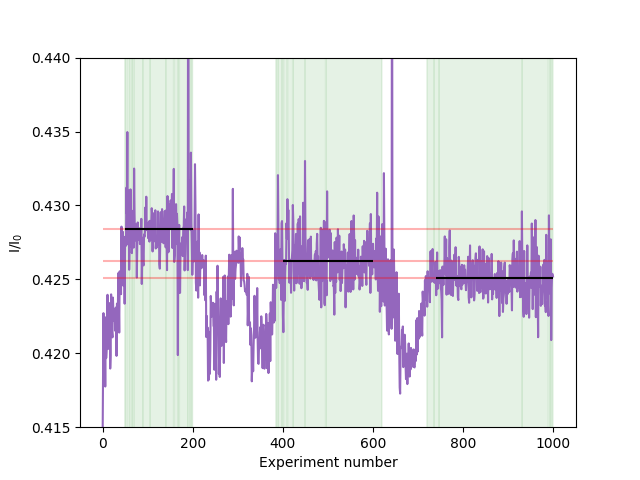

In [24]:
slices = np.array([[50, 200],
                   [400, 600],
                   [740, 1000]
                   ])
means = np.array([y_print[slice[0]:slice[1], 4].mean() for slice in slices])

plt.close()
plt.plot(y_print[:, 4], color='tab:purple')
plt.fill_between(np.arange(0, len(y_print)), 0, y.max()*mask, color='green', alpha=0.1)
plt.hlines(means, 0, 1000, colors='red', alpha=0.3)
for i in range(3):
    plt.hlines(means[i], slices[i, 0], slices[i, 1], colors='black')
plt.ylim(0.415, 0.44)
plt.ylabel(r'$ \rm I / I_0$')
plt.xlabel('Experiment number')
plt.show()

Test for normality in data distribution for 1000 experiments

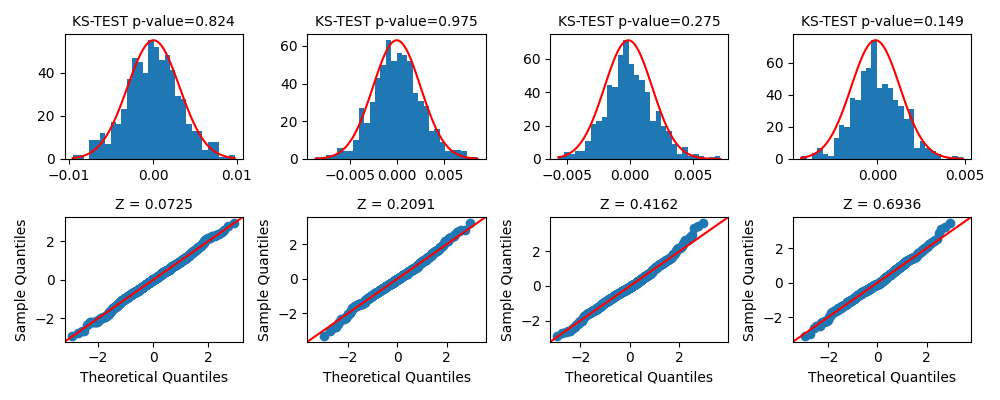

In [27]:
plt.close()
plt.figure(figsize=(10,4))
dist_type = norm
num_of_plots = 4
for i in range(1, 5):
    x_values = np.where(mask)[0]
    sl, inter ,_ ,_ ,_  = linregress(x_values, y.T[i])
    plt.subplot(2, num_of_plots, i)
    # y_data = y.T[i][90:-20] - butter_lowpass_filter(y.T[i], 0.3, 10)[110:]
    y_data = y.T[i] - (x_values * sl + inter)
    q16, q50, q84 = np.quantile(y_data, [0.159, 0.50, 0.841])
    _mean, _std = q50, (q84-q16)/2
    _hist_data, _bins, _ = plt.hist(y_data, bins=30, histtype='stepfilled')
    x_space = np.linspace(_bins[0], _bins[-1], 100)
    norm_dist = dist_type.pdf(x_space, *[_mean, _std])
    norm_dist = norm_dist/norm_dist.max() * _hist_data.max()
    plt.plot(x_space, norm_dist, c='red')
    ks_statistic, p_value = kstest(y_data, dist_type.cdf, args=(_mean, _std))
    plt.title(f'KS-TEST p-value={p_value:.3f}', fontsize=10)

    plt.subplot(2, num_of_plots, num_of_plots + i)
    _ = sm.qqplot(y_data, dist=dist_type, fit=True, line="45", ax=plt.gca())
    # plt.ylim(-3, 3)
    # plt.xlim(-3, 3)
    plt.title(f'Z = {x[0][i]:.4f}', fontsize=10)
plt.tight_layout()
plt.show()

Calculation of the error profile used in data

In [28]:
folder = path.joinpath('data', 'R2_5times')
x_arr = []
y_arr_norm = []
y_arr = []
for i in range(1, 6):
    data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-{i}.txt')
    x1, y1 = load_data(data_path)
    x2, y2 = np.loadtxt(data_path, skiprows=2, usecols=(1,2)).T
    x_arr.append(x1)
    y_arr_norm.append(y1)
    y_arr.append(y2)

y_arr_norm = np.vstack(y_arr_norm)
y_arr = np.vstack(y_arr)

In [29]:
cov_matrix = np.cov(y_arr.T)
var1 = cov_matrix[0,0] / y_arr.mean(0)[0] ** 2
var2 = np.diag(cov_matrix)[1:] / y_arr.mean(0)[1:] ** 2
covar = cov_matrix[0, 1:]/(y_arr.mean(0)[0] * y_arr.mean(0)[1:])

theor_std = (var1 + var2 - 2 * covar) ** 0.5

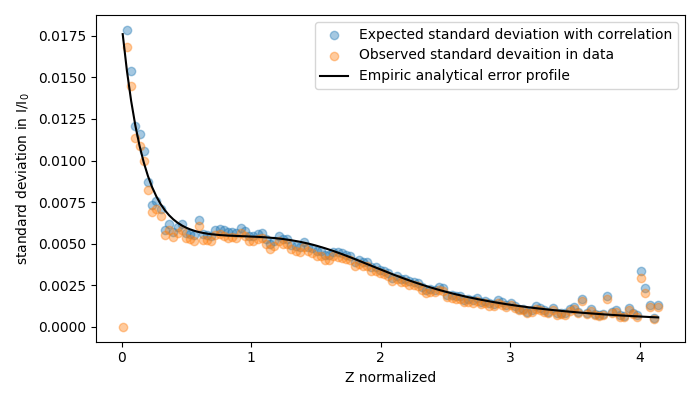

In [30]:
plt.close()
plt.figure(figsize=(7,4))
plt.scatter(x_arr[1][1:], theor_std * y_arr_norm.mean(0)[1:], alpha=0.4, label='Expected standard deviation with correlation')
plt.scatter(x_arr[1], y_arr_norm.std(0), alpha=0.4, label='Observed standard devaition in data')
plt.plot(x_arr[1], error_estimate(x_arr[1]), label='Empiric analytical error profile', color='black')
plt.ylabel(r'standard deviation in $\rm I/I_0$')
plt.xlabel('Z normalized')
plt.tight_layout()
plt.legend()
plt.show()